# Dealing with Low Confidence Situations

First we analyze a few scenarios where spurious examines or clicks result in inaccurate relevance grades. We then augment the SDBN judgments with a beta prior to better model the amount of confidence we have in the underlying click data.

In [1]:
! cd ../data/retrotech && head signals.csv

import random
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
from aips import *
from session_gen import SessionGenerator
import os
from IPython.core.display import display,HTML

import matplotlib.pyplot as plt
import numpy as np
# if using a Jupyter notebook, includue:
%matplotlib inline

"query_id","user","type","target","signal_time"
"u2_0_1","u2","query","nook","2019-07-31 08:49:07.3116"
"u2_1_2","u2","query","rca","2020-05-04 08:28:21.1848"
"u3_0_1","u3","query","macbook","2019-12-22 00:07:07.0152"
"u4_0_1","u4","query","Tv antenna","2019-08-22 23:45:54.1030"
"u5_0_1","u5","query","AC power cord","2019-10-20 08:27:00.1600"
"u6_0_1","u6","query","Watch The Throne","2019-09-18 11:59:53.7470"
"u7_0_1","u7","query","Camcorder","2020-02-25 13:02:29.3089"
"u9_0_1","u9","query","wireless headphones","2020-04-26 04:26:09.7198"
"u10_0_1","u10","query","Xbox","2019-09-13 16:26:12.0132"


In [2]:
def all_sessions():
    import glob
    sessions = pd.concat([pd.read_csv(f, compression='gzip')
                          for f in glob.glob('*_sessions.gz')])
    return sessions.rename(columns={'clicked_doc_id': 'doc_id'})
    
sessions = all_sessions()
sessions

,sess_id,query,rank,doc_id,clicked
0,2,dryer,0.0,12505451713,False
1,2,dryer,1.0,84691226727,True
2,2,dryer,2.0,883049066905,False
3,2,dryer,3.0,14381196320,False
4,2,dryer,4.0,74108056764,False
...,...,...,...,...,...
149995,55001,blue ray,25.0,22265004517,False
149996,55001,blue ray,26.0,885170038875,False
149997,55001,blue ray,27.0,786936817232,False
149998,55001,blue ray,28.0,600603132872,False


In [3]:
products = fetch_products(doc_ids=sessions['doc_id'].unique())

products

,image,upc,name,manufacturer,shortDescription,longDescription,id,_version_
0,"<img height=""100"" src=""../data/retrotech/image...",24543750949,X-Men: First Class - Widescreen Dubbed Subtitl...,\N,\N,\N,13b0b350-8832-46df-9aea-a8991af6534b,1684550853664440322
1,"<img height=""100"" src=""../data/retrotech/image...",803238004525,Headphones - CD,Suicide Squeeze,\N,\N,c2490d46-dd98-4b55-a594-1e064893d3dd,1684550853904564231
2,"<img height=""100"" src=""../data/retrotech/image...",883393003458,"RCA - 46"" Class - LCD - 1080p - 60Hz - HDTV",RCA,\N,This HDTV showcases stunning images up to 1080...,953d1c22-88d7-4009-a5f6-b0783a411a11,1684550854019907593
3,"<img height=""100"" src=""../data/retrotech/image...",843404064434,ZAGG - InvisibleSHIELD for Apple&#xAE; iPhone&...,ZAGG,Compatible with Apple&#xAE; iPhone&#xAE; 4; mi...,Protect your Apple iPhone 4's screen with this...,8355f53e-da62-4667-a86e-9fca0f927ad4,1684550854146785281
4,"<img height=""100"" src=""../data/retrotech/image...",600603135101,Rocketfish&#x2122; - Protective Cover for NOOK,Rocketfish&#x99;,Compatible with NOOK WiFi and NOOK 3G+WiFi; th...,Protect your NOOK eReader from bumps and scrat...,7346a389-ef33-448e-b7e8-45208226d43b,1684550854148882432
...,...,...,...,...,...,...,...,...
307,"<img height=""100"" src=""../data/retrotech/image...",97361455044,Thor (2011) (2 Disc) (W/Dvd) - Widescreen Dubb...,\N,\N,\N,1d19f238-5eac-4884-8866-b1cd84a2199c,1684550857352282117
308,"<img height=""100"" src=""../data/retrotech/image...",786936817232,Pirates Of The Caribbean: On Stranger Tides (2...,\N,\N,\N,fc0243b3-74aa-4625-aea3-8f62374046e8,1684550857360670725
309,"<img height=""100"" src=""../data/retrotech/image...",786936817218,Pirates Of The Caribbean: On Stranger Tides (3...,\N,\N,\N,94ac7204-2099-472c-b2ab-d75ec63cb613,1684550857360670727
310,"<img height=""100"" src=""../data/retrotech/image...",24543742180,Star Wars: The Complete Saga [9 Discs / Blu-ra...,\N,\N,\N,83071377-bcd3-44c3-a990-55aafeea01a2,1684550857673146372


## Listing 11.10

Computing SDBN judgments on transformers dark of the moon

In [4]:
QUERY='transformers dark of the moon'
sdbn_sessions = sessions[sessions['query'] == QUERY].copy().set_index('sess_id')

last_click_per_session = sdbn_sessions.groupby(['clicked', 'sess_id'])['rank'].max()[True]

sdbn_sessions['last_click_rank'] = last_click_per_session
sdbn_sessions['examined'] = sdbn_sessions['rank'] <= sdbn_sessions['last_click_rank']

sdbn = sdbn_sessions[sdbn_sessions['examined']].groupby('doc_id')[['clicked', 'examined']].sum()
sdbn['grade'] = sdbn['clicked'] / sdbn['examined']

sdbn = sdbn.sort_values('grade', ascending=False)
sdbn

,clicked,examined,grade
doc_id,,,
97360810042,412.0,642.0,0.641745
400192926087,62.0,129.0,0.480620
97363560449,96.0,243.0,0.395062
97363532149,42.0,130.0,0.323077
93624956037,41.0,154.0,0.266234
47875842328,367.0,1531.0,0.239713
47875841420,217.0,960.0,0.226042
25192107191,176.0,1082.0,0.162662
786936817218,118.0,777.0,0.151866


## Listing 11.11

Computing relevance judgments for "blue ray" a simulated tail query

In [5]:
QUERY='blue ray'
# Simulate a rare query by slicing out some data
sdbn_sessions = sessions[sessions['query'] == QUERY]
sdbn_sessions = sdbn_sessions[sdbn_sessions['sess_id'] < 50050]
sdbn_sessions = sdbn_sessions.set_index('sess_id')

last_click_per_session = sdbn_sessions.groupby(['clicked', 'sess_id'])['rank'].max()[True]

sdbn_sessions['last_click_rank'] = last_click_per_session
sdbn_sessions['examined'] = sdbn_sessions['rank'] <= sdbn_sessions['last_click_rank']

sdbn = sdbn_sessions[sdbn_sessions['examined']].groupby('doc_id')[['clicked', 'examined']].sum()
sdbn['grade'] = sdbn['clicked'] / sdbn['examined']

sdbn = sdbn.sort_values('grade', ascending=False)
sdbn

,clicked,examined,grade
doc_id,,,
600603132872,1.0,1.0,1.000000
827396513927,14.0,34.0,0.411765
25192073007,8.0,20.0,0.400000
885170033412,6.0,19.0,0.315789
600603141003,8.0,26.0,0.307692
24543672067,8.0,27.0,0.296296
813774010904,2.0,7.0,0.285714
883929140855,2.0,7.0,0.285714
22265052211,1.0,4.0,0.250000


# Figure 11.9

Beta distribution for grade=0.125

a=2.5 b=17.5


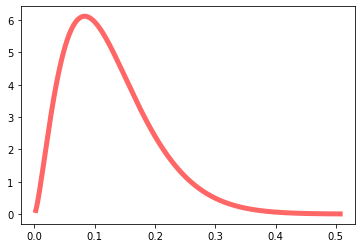

In [6]:
from scipy.stats import beta

prior_grade = 0.125

prior_weight = 20
a=prior_grade*prior_weight; b=(1-prior_grade)*prior_weight
print(f"a={a} b={b}")

x = np.linspace(beta.ppf(0.0001, a, b), beta.ppf(0.9999, a, b), 10000)
fig, ax = plt.subplots(1, 1)

ax.plot(x, beta.pdf(x, a, b),
        'r-', lw=5, alpha=0.6, label='beta pdf')

# Figure 11.10

Adding clicks to the beta distribution

a=3.5 b=17.5


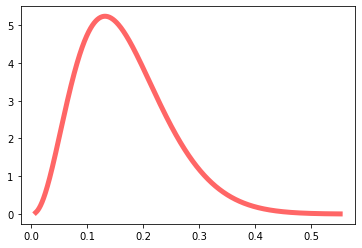

In [7]:
# Fit a beta prior to global_ctr
a+=1
print(f"a={a} b={b}")

x = np.linspace(beta.ppf(0.0001, a, b), beta.ppf(0.9999, a, b), 10000)
fig, ax = plt.subplots(1, 1)

ax.plot(x, beta.pdf(x, a, b),
        'r-', lw=5, alpha=0.6, label='beta pdf')

## Listing 11.12

Starting with a prior beta distribution for each document for "blue ray"

In [8]:
PRIOR_GRADE=0.3
PRIOR_WEIGHT=100
sdbn['prior_a'] = PRIOR_GRADE*PRIOR_WEIGHT
sdbn['prior_b'] = (1-PRIOR_GRADE)*PRIOR_WEIGHT

sdbn

,clicked,examined,grade,prior_a,prior_b
doc_id,,,,,
600603132872,1.0,1.0,1.000000,30.0,70.0
827396513927,14.0,34.0,0.411765,30.0,70.0
25192073007,8.0,20.0,0.400000,30.0,70.0
885170033412,6.0,19.0,0.315789,30.0,70.0
600603141003,8.0,26.0,0.307692,30.0,70.0
24543672067,8.0,27.0,0.296296,30.0,70.0
813774010904,2.0,7.0,0.285714,30.0,70.0
883929140855,2.0,7.0,0.285714,30.0,70.0
22265052211,1.0,4.0,0.250000,30.0,70.0


## Listing 11.13

Here we update the beta posterior to account for the observations in our data

In [9]:
sdbn['posterior_a'] = sdbn['prior_a'] +  sdbn['clicked']
sdbn['posterior_b'] = sdbn['prior_b'] + (sdbn['examined'] - sdbn['clicked'])

sdbn['beta_grade'] = sdbn['posterior_a'] / (sdbn['posterior_a'] + sdbn['posterior_b'])

sdbn.sort_values('beta_grade', ascending=False)

,clicked,examined,grade,prior_a,prior_b,posterior_a,posterior_b,beta_grade
doc_id,,,,,,,,
827396513927,14.0,34.0,0.411765,30.0,70.0,44.0,90.0,0.328358
25192073007,8.0,20.0,0.400000,30.0,70.0,38.0,82.0,0.316667
600603132872,1.0,1.0,1.000000,30.0,70.0,31.0,70.0,0.306931
885170033412,6.0,19.0,0.315789,30.0,70.0,36.0,83.0,0.302521
600603141003,8.0,26.0,0.307692,30.0,70.0,38.0,88.0,0.301587
24543672067,8.0,27.0,0.296296,30.0,70.0,38.0,89.0,0.299213
813774010904,2.0,7.0,0.285714,30.0,70.0,32.0,75.0,0.299065
883929140855,2.0,7.0,0.285714,30.0,70.0,32.0,75.0,0.299065
22265052211,1.0,4.0,0.250000,30.0,70.0,31.0,73.0,0.298077


In [17]:
sdbn = sdbn.sort_values('beta_grade', ascending=False).reset_index()
sdbn

,doc_id,clicked,examined,grade,prior_a,prior_b,posterior_a,posterior_b,beta_grade
0,827396513927,14.0,34.0,0.411765,30.0,70.0,44.0,90.0,0.328358
1,25192073007,8.0,20.0,0.400000,30.0,70.0,38.0,82.0,0.316667
2,600603132872,1.0,1.0,1.000000,30.0,70.0,31.0,70.0,0.306931
3,885170033412,6.0,19.0,0.315789,30.0,70.0,36.0,83.0,0.302521
4,600603141003,8.0,26.0,0.307692,30.0,70.0,38.0,88.0,0.301587
5,24543672067,8.0,27.0,0.296296,30.0,70.0,38.0,89.0,0.299213
6,813774010904,2.0,7.0,0.285714,30.0,70.0,32.0,75.0,0.299065
7,883929140855,2.0,7.0,0.285714,30.0,70.0,32.0,75.0,0.299065
8,22265052211,1.0,4.0,0.250000,30.0,70.0,31.0,73.0,0.298077
9,786936817232,2.0,8.0,0.250000,30.0,70.0,32.0,76.0,0.296296


In [18]:
render_judged(products, 
              sdbn, 
              grade_col='beta_grade',
              label=f"SDBN judgments for q={QUERY}")

,beta_grade,image,upc,name,shortDescription
0,0.328358,,8.273965e+11,Panasonic - Refurbished Wi-Fi Ready Blu-ray Disc Player,RefurbishedPlays DVD and Blu-ray Discs; 1080p upconversion; 2-channel analog output104.99
1,0.316667,NaN,NaN,NaN,NaN
2,0.306931,,6.006031e+11,Dynex™ - Blu-ray Disc Cases (10-Pack),Also compatible with DVDs and CDs; 10 pack; fits 2 discs per case
3,0.302521,,8.851700e+11,Panasonic - Blu-ray Player,ENERGY STAR QualifiedPlays DVD and Blu-ray Discs; HDMI output; analog audio outLearn more about smart products.
4,0.301587,,6.006031e+11,"Dynex™ - 9"" Portable DVD Player","Plays DVD, DVD+/-R/RW, CD, CD-R/RW and JPEG formats; up to 2.5 hours of playback; headphone jack"
5,0.299213,,2.454367e+10,Predators - Widescreen Dubbed Subtitle AC3 - Blu-ray Disc,\N
6,0.299065,,8.137740e+11,Samsung - Refurbished Wi-Fi Ready Blu-ray Player with HDMI Cable,RefurbishedENERGY STAR QualifiedPlays DVD and Blu-ray Discs; 1080p video output; 2-channel audio outputLearn more about smart products.
7,0.299065,,8.839291e+11,Green Lantern - Blu-ray Disc,\N
8,0.298077,,2.226505e+10,Toshiba - Wi-Fi Ready Blu-ray Player,ENERGY STAR QualifiedPlays DVD and Blu-ray; 1080p HD video output;Learn more about smart products.
9,0.296296,,7.869368e+11,Pirates Of The Caribbean: On Stranger Tides (2 Disc) - Blu-ray Disc,\N


In [20]:
products[products['upc'] == 25192073007]

,image,upc,name,manufacturer,shortDescription,longDescription,id,_version_


# Figure 11.10 source code

Rendering beta distribution updated judgments to model our confidence in them

In [23]:
QUERY='transformers dark of the moon'
sdbn_sessions = sessions[sessions['query'] == QUERY].copy().set_index('sess_id')

last_click_per_session = sdbn_sessions.groupby(['clicked', 'sess_id'])['rank'].max()[True]

sdbn_sessions['last_click_rank'] = last_click_per_session
sdbn_sessions['examined'] = sdbn_sessions['rank'] <= sdbn_sessions['last_click_rank']

sdbn = sdbn_sessions[sdbn_sessions['examined']].groupby('doc_id')[['clicked', 'examined']].sum()
sdbn['grade'] = sdbn['clicked'] / sdbn['examined']

sdbn = sdbn.sort_values('grade', ascending=False)

PRIOR_GRADE=0.3
PRIOR_WEIGHT=100
sdbn['prior_a'] = PRIOR_GRADE*PRIOR_WEIGHT
sdbn['prior_b'] = (1-PRIOR_GRADE)*PRIOR_WEIGHT

sdbn['posterior_a'] = sdbn['prior_a'] +  sdbn['clicked']
sdbn['posterior_b'] = sdbn['prior_b'] + (sdbn['examined'] - sdbn['clicked'])

sdbn['beta_grade'] = sdbn['posterior_a'] / (sdbn['posterior_a'] + sdbn['posterior_b'])

sdbn.sort_values('beta_grade', ascending=False)

render_judged(products, 
              sdbn, 
              grade_col='beta_grade',
              label=f"Conf. Adjusted SDBN judgments for q={QUERY}")

,beta_grade,image,upc,name,shortDescription
0,0.595687,,97360810042,Transformers: Dark of the Moon - Blu-ray Disc,\N
1,0.401747,,400192926087,Transformers: Dark of the Moon - Original Soundtrack - CD,\N
2,0.367347,,97363560449,Transformers: Dark of the Moon - Widescreen Dubbed Subtitle - DVD,\N
3,0.313043,,97363532149,Transformers: Revenge of the Fallen - Widescreen Dubbed Subtitle - DVD,\N
4,0.279528,,93624956037,Transformers: Dark of the Moon - Original Soundtrack - CD,\N
5,0.243409,,47875842328,Transformers: Dark of the Moon Stealth Force Edition - Nintendo Wii,Transform into an epic hero or a vehicular villain
6,0.233019,,47875841420,Transformers: Dark of the Moon Decepticons - Nintendo DS,Transform into an epic hero or a vehicular villain
7,0.174281,,25192107191,Fast Five - Widescreen - Blu-ray Disc,\N
8,0.168757,,786936817218,Pirates Of The Caribbean: On Stranger Tides (3-D) - Blu-ray 3D,\N
9,0.188329,,36725235564,"Samsung - 40"" Class - LCD - 1080p - 120Hz - HDTV",\N


# Figure 11.11 source code

Rendering beta distribution updated judgments to model our confidence in them

In [25]:
QUERY='dryer'
sdbn_sessions = sessions[sessions['query'] == QUERY].copy().set_index('sess_id')

last_click_per_session = sdbn_sessions.groupby(['clicked', 'sess_id'])['rank'].max()[True]

sdbn_sessions['last_click_rank'] = last_click_per_session
sdbn_sessions['examined'] = sdbn_sessions['rank'] <= sdbn_sessions['last_click_rank']

sdbn = sdbn_sessions[sdbn_sessions['examined']].groupby('doc_id')[['clicked', 'examined']].sum()
sdbn['grade'] = sdbn['clicked'] / sdbn['examined']

sdbn = sdbn.sort_values('grade', ascending=False)

PRIOR_GRADE=0.3
PRIOR_WEIGHT=100
sdbn['prior_a'] = PRIOR_GRADE*PRIOR_WEIGHT
sdbn['prior_b'] = (1-PRIOR_GRADE)*PRIOR_WEIGHT

sdbn['posterior_a'] = sdbn['prior_a'] +  sdbn['clicked']
sdbn['posterior_b'] = sdbn['prior_b'] + (sdbn['examined'] - sdbn['clicked'])

sdbn['beta_grade'] = sdbn['posterior_a'] / (sdbn['posterior_a'] + sdbn['posterior_b'])

sdbn.sort_values('beta_grade', ascending=False)

render_judged(products, 
              sdbn, 
              grade_col='beta_grade',
              label=f"Conf. Adjusted SDBN judgments for q={QUERY}")

,beta_grade,image,upc,name,shortDescription
0,0.385343,,856751002097,Practecol - Dryer Balls (2-Pack),"Suitable for use on most dry cycles; reduces lint, static and wrinkles; improves heat circulation; 2-pack"
1,0.374761,,48231011396,LG - 3.5 Cu. Ft. 7-Cycle High-Efficiency Washer - White,ENERGY STAR QualifiedDigital controls; 7 cycles; SpeedWash cycle; 9 wash options; delay-wash; SenseClean system; 6Motion technology; TrueBalance antivibration system
2,0.315789,,84691226727,GE - 6.0 Cu. Ft. 3-Cycle Electric Dryer - White,Rotary electromechanical controls; 3 cycles; 3 heat selections; DuraDrum interior; Quiet-By-Design
3,0.294554,,74108007469,Conair - 1875-Watt Folding Handle Hair Dryer - Blue,2 heat/speed settings; cool shot button; dual voltage; professional-length line cord
4,0.277467,,12505525766,Smart Choice - 6' 30 Amp 3-Prong Dryer Cord,Heavy-duty PVC insulation; strain relief safety clamp
5,0.277296,,36725578241,Samsung - 7.3 Cu. Ft. 7-Cycle Electric Dryer - White,Soft-touch dial controls; 7 preset drying cycles; 4 temperature settings; powdercoat drum; noise reduction package
6,0.264706,,48231011402,LG - 7.1 Cu. Ft. 7-Cycle Electric Dryer - White,Electronic controls with LED display; 7 cycles; Dial-A-Cycle option; sensor dry system; 5 temperature levels; 5 drying levels; NeveRust drum; LoDecibel quiet operation
7,0.265152,,12505527456,"Smart Choice - 1/2"" Safety+PLUS Stainless-Steel Gas Dryer Connector","Safety+PLUS automatic shut-off valve; leak detection solution; pipe thread sealant; 60,500 BTU; CSA approved"
8,0.221387,,74108096487,Conair - Infiniti Cord-Keeper Professional Tourmaline Ionic Hair Dryer - Fuchsia,Tourmaline ceramic technology; ionic technology; 1875 watts; Cool Shot function; 3 heat settings; 2 speed settings; 5' retractable cord; includes diffuser
9,0.221726,,36725561977,Samsung - 3.5 Cu. Ft. 6-Cycle High-Efficiency Washer - White,ENERGY STAR QualifiedSoft dial touch pad controls; 6 cycles; delay-start; child lock; Vibration Reduction Technology


In [82]:
# Generate some features (similar to feature logging in chapter 10)

categories = {
    883929085118: 'movie',
    36172950027: 'music',
    12505451713: 'washer dryer accesories',
    883049066905: 'washer dryer accesories',
    74108056764: 'personal health and hygiene',
    77283045400: 'personal health and hygiene',
    14381196320: 'movie',
    783722274422: 'movie',
    665331101927: 'music',
    84691226703: 'washer dryer',
    36725561977: 'washer dryer',
    12505525766: 'washer dryer accesories',
    12505527456: 'washer dryer accesories',
    74108007469: 'personal health and hygiene',
    84691226727: 'washer dryer',
    48231011396: 'washer dryer',
    856751002097: 'washer dryer accesories',
    36725578241: 'washer dryer',
    48231011402: 'washer dryer',
    74108096487: 'personal health and hygiene',
}
categories = pd.Series(categories)

title_term_count = {
    883929085118: 0,
    36172950027: 1,
    12505451713: 1,
    883049066905: 0,
    74108056764: 1,
    77283045400: 1,
    14381196320: 0,
    783722274422: 0,
    665331101927: 0,
    84691226703: 1,
    36725561977: 0,
    12505525766: 1,
    12505527456: 1,
    74108007469: 1,
    84691226727: 1,
    48231011396: 0,
    856751002097: 1,
    36725578241: 1,
    48231011402: 1,
    74108096487: 1,
}
title_term_count = pd.Series(title_term_count)

all_categories = list(set(categories.values)) + ['video games', 'televisions', 'home audio', 'kitchen']



sdbn_with_features = sdbn[['beta_grade', 'clicked', 'examined', 'posterior_a', 'posterior_b']].copy()
sdbn_with_features = sdbn_with_features.rename(columns={'posterior_a': 'a','posterior_b': 'b'})
sdbn_with_features['categories'] = categories
sdbn_with_features['category_index'] = categories.apply(lambda cat: all_categories.index(cat))
sdbn_with_features['title_term_count'] = title_term_count
sdbn_with_features['variance'] = sdbn_with_features['a'] * sdbn_with_features['b'] /\
    ((sdbn_with_features['a'] + sdbn_with_features['b'] + 1) * (sdbn_with_features['a'] + sdbn_with_features['b'])**2)


sdbn_with_features

,beta_grade,clicked,examined,a,b,categories,category_index,title_term_count,variance
doc_id,,,,,,,,,
856751002097,0.385343,133.0,323.0,163.0,260.0,washer dryer accesories,4,1,0.000559
48231011396,0.374761,166.0,423.0,196.0,327.0,washer dryer,3,0,0.000447
84691226727,0.315789,804.0,2541.0,834.0,1807.0,washer dryer,3,1,0.000082
74108007469,0.294554,208.0,708.0,238.0,570.0,personal health and hygiene,1,1,0.000257
12505525766,0.277467,268.0,974.0,298.0,776.0,washer dryer accesories,4,1,0.000186
36725578241,0.277296,130.0,477.0,160.0,417.0,washer dryer,3,1,0.000347
48231011402,0.264706,213.0,818.0,243.0,675.0,washer dryer,3,1,0.000212
12505527456,0.265152,110.0,428.0,140.0,388.0,washer dryer accesories,4,1,0.000368
74108096487,0.221387,235.0,1097.0,265.0,932.0,personal health and hygiene,1,1,0.000144


In [83]:
from sklearn.gaussian_process import GaussianProcessRegressor

y_train = sdbn_with_features['beta_grade']
x_train = sdbn_with_features[['category_index', 'title_term_count']]

gpr=GaussianProcessRegressor(alpha=sdbn_with_features['variance'])
gpr.fit(x_train, y_train)

GaussianProcessRegressor(alpha=doc_id
856751002097    0.000559
48231011396     0.000447
84691226727     0.000082
74108007469     0.000257
12505525766     0.000186
36725578241     0.000347
48231011402     0.000212
12505527456     0.000368
74108096487     0.000144
36725561977     0.000256
84691226703     0.000078
665331101927    0.000113
783722274422    0.000100
14381196320     0.000118
77283045400     0.000085
74108056764     0.000071
883049066905    0.000054
12505451713     0.000042
36172950027     0.000097
883929085118    0.000143
Name: variance, dtype: float64,
                         copy_X_train=True, kernel=None, n_restarts_optimizer=0,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)

In [88]:
possible_explore = np.array([5,1]).reshape(1,-1)
gpr.predict(possible_explore, return_std=True)

(array([0.02476259]), array([0.71350964]))

(array([3.22226038e-07]), array([1.]))

In [34]:
products

,image,upc,name,manufacturer,shortDescription,longDescription,id,_version_
0,"<img height=""100"" src=""../data/retrotech/image...",24543750949,X-Men: First Class - Widescreen Dubbed Subtitl...,\N,\N,\N,13b0b350-8832-46df-9aea-a8991af6534b,1684550853664440322
1,"<img height=""100"" src=""../data/retrotech/image...",803238004525,Headphones - CD,Suicide Squeeze,\N,\N,c2490d46-dd98-4b55-a594-1e064893d3dd,1684550853904564231
2,"<img height=""100"" src=""../data/retrotech/image...",883393003458,"RCA - 46"" Class - LCD - 1080p - 60Hz - HDTV",RCA,\N,This HDTV showcases stunning images up to 1080...,953d1c22-88d7-4009-a5f6-b0783a411a11,1684550854019907593
3,"<img height=""100"" src=""../data/retrotech/image...",843404064434,ZAGG - InvisibleSHIELD for Apple&#xAE; iPhone&...,ZAGG,Compatible with Apple&#xAE; iPhone&#xAE; 4; mi...,Protect your Apple iPhone 4's screen with this...,8355f53e-da62-4667-a86e-9fca0f927ad4,1684550854146785281
4,"<img height=""100"" src=""../data/retrotech/image...",600603135101,Rocketfish&#x2122; - Protective Cover for NOOK,Rocketfish&#x99;,Compatible with NOOK WiFi and NOOK 3G+WiFi; th...,Protect your NOOK eReader from bumps and scrat...,7346a389-ef33-448e-b7e8-45208226d43b,1684550854148882432
...,...,...,...,...,...,...,...,...
307,"<img height=""100"" src=""../data/retrotech/image...",97361455044,Thor (2011) (2 Disc) (W/Dvd) - Widescreen Dubb...,\N,\N,\N,1d19f238-5eac-4884-8866-b1cd84a2199c,1684550857352282117
308,"<img height=""100"" src=""../data/retrotech/image...",786936817232,Pirates Of The Caribbean: On Stranger Tides (2...,\N,\N,\N,fc0243b3-74aa-4625-aea3-8f62374046e8,1684550857360670725
309,"<img height=""100"" src=""../data/retrotech/image...",786936817218,Pirates Of The Caribbean: On Stranger Tides (3...,\N,\N,\N,94ac7204-2099-472c-b2ab-d75ec63cb613,1684550857360670727
310,"<img height=""100"" src=""../data/retrotech/image...",24543742180,Star Wars: The Complete Saga [9 Discs / Blu-ra...,\N,\N,\N,83071377-bcd3-44c3-a990-55aafeea01a2,1684550857673146372


In [85]:
mean, var, skew, kurt = beta.stats(70, 30, moments='mvsk')

In [86]:
var

array(0.00207921)

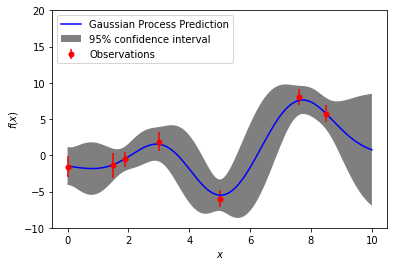

In [119]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)


def f(x):
    """The function to predict."""
    return x * np.sin(x) 

# Noisy Gaussian Process graph, adapted from
# https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html
X = np.array([0,1.5,1.9,3.0,5.0,7.6, 8.5])
X = np.atleast_2d(X).T

# Observations and noise
y = f(X).ravel()
dy = 1 + np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise

# Instantiate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, alpha=dy ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Gaussian Process Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='black', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

plt.show()

In [106]:
X

array([[0.1       ],
       [0.51052632],
       [0.92105263],
       [1.33157895],
       [1.74210526],
       [2.15263158],
       [2.56315789],
       [2.97368421],
       [3.38421053],
       [3.79473684],
       [4.20526316],
       [4.61578947],
       [5.02631579],
       [5.43684211],
       [5.84736842],
       [6.25789474],
       [6.66842105],
       [7.07894737],
       [7.48947368],
       [7.9       ]])